In [1]:
maf_file_path = 'data/RESPOND_247_coding_final.maf'
expression_file_path = 'data/Expression_remove_BE.txt'
target_gene='RPL10'

import pandas as pd
import numpy as np
from statistics import mean 
from scipy.stats import ranksums
import matplotlib.pylab as plt
from statsmodels.stats import multitest


In [2]:
def load_maf_data(file_path):
    # Define columns of interest
    columns = ["Hugo_Symbol", "Tumor_Sample_Barcode"]
    df = pd.read_csv(file_path, sep='\t', comment="#", usecols=columns)
    df.rename(columns={'Hugo_Symbol': 'gene', 'Tumor_Sample_Barcode': 'sample'}, inplace=True)
    df['mutation'] = 1
    return df
    
maf_df = load_maf_data(maf_file_path)



In [3]:
def log2(value):
    return np.log2(value + 1)

def load_txt_file_into_dataframe(file_path):
    # Read the .txt file into a pandas DataFrame
    df = pd.read_csv(file_path, sep='\t')  # Adjust the separator if needed

    # take log2 of expression data to scale expression data
    df = df.map(log2)

    return df


# Call the load_txt_file_into_dataframe function
expression_df = load_txt_file_into_dataframe(expression_file_path)

In [4]:
def reformat_expression_data(df):
    # Combine column names and index names into rows for every element
    melted_df = pd.melt(df.reset_index(), id_vars=['index'], var_name='column', col_level=0)

    # Rename columns
    melted_df.rename(columns={'index': 'gene', 'column': 'sample', 'value': 'gene_expression'}, inplace=True)

    return melted_df


expression_df_melted = reformat_expression_data(expression_df)

In [5]:
# note individuals with muttated data mmay be missing in the expression data and vice versa. 
# every sample should have at least one mutation 

In [6]:
def preprocess_and_combine_mutation_expression(maf_df, expression_df):
    ''' filter the expression data to those that have whole genome sequencing 
     i.e. appear in the mutation data frame (maf)
     join mutation and expression data
     '''
    
    exon_seq_samples = maf_df['sample'].unique()
    filtered_expression_df = expression_df[expression_df['sample'].isin(exon_seq_samples)]
    
    all_rows = expression_df.shape[0]
    filt_rows = filtered_expression_df.shape[0]
    
    percentage_filtered = (all_rows - filt_rows) / all_rows
    
    print('fraction of rows filtered is', percentage_filtered)

    express_mut_genes_df = pd.merge(maf_df, filtered_expression_df, on=['gene', 'sample'], how='right')

    express_mut_genes_df['mutation'].fillna(0, inplace=True)

    return express_mut_genes_df


mutation_expression_df_melted =  preprocess_and_combine_mutation_expression(maf_df, expression_df_melted)
    

fraction of rows filtered is 0.2865853658536585


In [7]:
def calculate_log_fold(list_mutated, list_non_mutated): 
    mean_mutated = mean(list_mutated)
    mean_non_mutated = mean(list_non_mutated) + 0.000001
    return np.log2(mean_mutated/mean_non_mutated)

In [8]:
def calculate_pvalue_wilcox_ranksum(list_mutated, list_non_mutated):
     return ranksums(list_mutated, list_non_mutated).pvalue

In [9]:
def calculate_adjusted_pvalue(pvalues, method='fdr_bh'):
    _, corrected_pvalues, _, _ = multitest.multipletests(pvalues, method=method)
    return corrected_pvalues


In [10]:
def generate_stats_per_gene(express_mut_genes_df, target_gene):
    """
    Given expression and mutation data calculates LogFC, pvalue, mean of expression per gene 
    for a given target_gene 
    
    """
    gene_df = express_mut_genes_df[express_mut_genes_df['gene']==target_gene]

    mutated_samples = gene_df[gene_df['mutation'] == 1]['sample']
    non_mutated_samples = gene_df[gene_df['mutation'] == 0]['sample']
    
    mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(mutated_samples)]
    
    non_mutated_individuals_expression = express_mut_genes_df[express_mut_genes_df['sample'].isin(non_mutated_samples)]

    # gather data of mutated and non-mutated genes into lists
    mutated_individuals_data = mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_mutated'})
    non_mutated_individuals_data = non_mutated_individuals_expression.groupby(['gene'])['gene_expression'].apply(
    lambda x: list(x)).to_frame().reset_index().rename(columns={'gene_expression': 'gene_expression_non_mutated'})

    # combine mutated and unmutated data into one df
    combined_data= pd.merge(mutated_individuals_data, non_mutated_individuals_data, on='gene', how='inner')

    # calculate fold change and p-value
    combined_data['logFC']= combined_data.apply(
        lambda x: calculate_log_fold(x.gene_expression_mutated, x.gene_expression_non_mutated), axis=1)
    combined_data['pvalue'] = combined_data.apply(
        lambda x: calculate_pvalue_wilcox_ranksum(x.gene_expression_mutated, x.gene_expression_non_mutated), axis=1)
    combined_data['expression_mutated_mean'] = combined_data['gene_expression_mutated'].apply(mean)
    combined_data['expression_nonmutated_mean'] = combined_data['gene_expression_non_mutated'].apply(mean)
 
    # Clip outliers in 'logFC' column
    combined_data['logFC'] = combined_data['logFC'].clip(lower=-10, upper=10)

    # calculate adjusted p-value
    combined_data['adjusted_pvalue'] = calculate_adjusted_pvalue(combined_data['pvalue'].values)

    # Output data to csv 
    combined_data.drop(columns=['gene_expression_mutated', 'gene_expression_non_mutated'], inplace=True)
    
    output_file_path_name = f'{mutated_samples.count()}_{non_mutated_samples.count()}_{target_gene}'
    print(f"outputting data to {output_file_path_name}")
    combined_data.to_csv(output_file_path_name, index=False)

    return combined_data, output_file_path_name, mutated_samples


In [11]:
volcano_plot_df, gene_file_path, individuals_mutated_target_gene = generate_stats_per_gene(mutation_expression_df_melted, target_gene)

/var/folders/87/3s003r291fv10lqn34cwt0c80000gn/T/ipykernel_7833/2450995287.py:4: RuntimeWarning: divide by zero encountered in log2
  return np.log2(mean_mutated/mean_non_mutated)


outputting data to 5_112_RPL10


In [12]:
volcano_plot_df.head(4)

,gene,logFC,pvalue,expression_mutated_mean,expression_nonmutated_mean,adjusted_pvalue
0,A1BG,-0.357607,0.526496,1.796602,2.301983,0.996941
1,A1CF,0.419185,0.589864,0.770841,0.576470,0.996941
2,A2M,-0.058985,0.496169,7.180720,7.480391,0.996941
3,A2ML1,0.544968,0.140050,1.805403,1.237434,0.996941


## generate heatmap of top 100 differentially expressed genes

In [13]:
def generate_expression_heatmap(expression_df, volcano_plot_df, n=100, exclude_value=10):
    # Get the indices of the top n rows based on absolute values of 'logFC'
    # get the genes most differentially expressed (high log FC values)
    # if we exclude -exclude_value, exclude_value values
    top_n_indices = volcano_plot_df[
        (volcano_plot_df['logFC'].abs() != exclude_value)
    ]['logFC'].abs().nlargest(n).index
    
    top_n_rows = volcano_plot_df.loc[top_n_indices].set_index('gene')

    # go back to the expression df and make a heatmap of the top n genes
    expression_df_heatmap = expression_df.loc[top_n_rows.index]
    
    return expression_df_heatmap

heatmap_data = generate_expression_heatmap(expression_df, volcano_plot_df)


In [14]:
heatmap_data.head(3)

,RESPOND_10100218,RESPOND_10100291,RESPOND_10100412,RESPOND_10100478,RESPOND_10100596,RESPOND_10100615,RESPOND_10100801,RESPOND_10100884,RESPOND_10100899,RESPOND_10100952,...,RESPOND_80100242,RESPOND_80100313,RESPOND_80100345,RESPOND_80100411,RESPOND_80100526,RESPOND_80100556,RESPOND_80100590,RESPOND_81100031,RESPOND_40100842,RESPOND_80100259
gene,,,,,,,,,,,,,,,,,,,,,
TMEM238L,0.0,0.0,0.0,0.0,0.000012,0.0,0.000003,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000025,0.0
RN7SL321P,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
RNVU1-19,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.915644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471448,0.0


In [100]:
# can check mutation status of genes by checking individuals_mutated_target_gene

In [18]:
import pandas as pd

def get_mutated_status(expression_df_heatmap, individuals_mutated_target_gene):
    individuals_mutated_target_gene = list(individuals_mutated_target_gene)
    
    mutated_status = [1 if item in individuals_mutated_target_gene else 0 for item in expression_df_heatmap.columns]

    sample_categories_df = pd.DataFrame({
        'Sample': expression_df_heatmap.columns,
        'Mutation Status': mutated_status
    })

    return sample_categories_df

mutated_status_df = get_mutated_status(heatmap_data, individuals_mutated_target_gene)


In [22]:
mutated_status_df

,Sample,Mutation Status
0,RESPOND_10100218,0
1,RESPOND_10100291,0
2,RESPOND_10100412,0
3,RESPOND_10100478,0
4,RESPOND_10100596,0
...,...,...
159,RESPOND_80100556,0
160,RESPOND_80100590,0
161,RESPOND_81100031,0
162,RESPOND_40100842,0


In [ ]:
##to do: filter expression data for those included in the analysis (we have mutation data for)?

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage

def hierarchical_clustering(expression_df_heatmap, row_threshold=7, col_threshold=7):
    # Cluster the rows and columns using hierarchical clustering
    row_linkage = linkage(expression_df_heatmap, method='ward')
    col_linkage = linkage(expression_df_heatmap.T, method='ward')

    # Assign cluster labels using cluster
    row_clusters = fcluster(row_linkage, t=row_threshold, criterion='maxclust')
    col_clusters = fcluster(col_linkage, t=col_threshold, criterion='maxclust')

    # Create dictionaries to store cluster information
    row_cluster_info = {f"Cluster {cluster}": expression_df_heatmap.index[row_clusters == cluster] for cluster in np.unique(row_clusters)}
    col_cluster_info = {f"Cluster {cluster}": expression_df_heatmap.columns[col_clusters == cluster] for cluster in np.unique(col_clusters)}

    return row_linkage, col_linkage, row_cluster_info, col_cluster_info

# Example usage:
row_linkage, col_linkage, row_clusters, col_clusters = hierarchical_clustering(heatmap_data)


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_clustered_heatmap_and_save(expression_df_heatmap, 
                                      row_linkage, 
                                      col_linkage, 
                                      sample_mutation_df, 
                                      output_filename):
    # Group labels and colors for color bar
    type_map = {1: 'red', 0: 'yellow'}

    # Create a clustered heatmap
    clustered_df = sns.clustermap(
        expression_df_heatmap,
        row_linkage=row_linkage,
        col_linkage=col_linkage,
        cmap='viridis',
        annot=True,
        fmt=".1f",
        linewidths=.5,
        col_colors=sample_mutation_df.set_index('Sample')['Mutation Status'].map(type_map),
        standard_scale=0  # standardize by the rows
    )

    # Save the plot to a file
    clustered_df.savefig(output_filename)

    # Close the plot to prevent displaying it in the notebook (optional)
    plt.close()

    return clustered_df

output_file_path_name = f'{target_gene}_heatmap'
clustered_heatmap = create_clustered_heatmap_and_save(heatmap_data, 
                                                      row_linkage, 
                                                      col_linkage,
                                                      mutated_status_df, 
                                                      output_file_path_name)


In [29]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

## add more args to the function 

def plot_and_save_dendrograms(row_linkage, col_linkage, expression_df_heatmap, output_folder='.'):
    # Plot the row dendrogram
    plt.figure(figsize=(12, 6))
    gene_plot = dendrogram(row_linkage, 
                           labels=expression_df_heatmap.index, 
                           truncate_mode='lastp', 
                           p=int(0.75 * len(row_linkage)), show_leaf_counts=True)
    plt.title('Row Dendrogram')
    
    # Save the row dendrogram plot to a file
    row_dendrogram_filename = f'{output_folder}/row_dendrogram_{target_gene}.png'
    plt.savefig(row_dendrogram_filename)
    plt.close()

    # Plot the column dendrogram
    plt.figure(figsize=(12, 6))
    sample_plot = dendrogram(col_linkage, labels=expression_df_heatmap.columns, orientation='top', 
                             truncate_mode='lastp', p=int(0.75 * len(row_linkage)), show_leaf_counts=True)
    plt.title('Column Dendrogram')
    
    # Save the column dendrogram plot to a file
    col_dendrogram_filename = f'{output_folder}/col_dendrogram_{target_gene}.png'
    plt.savefig(col_dendrogram_filename)
    plt.close()

    return gene_plot, sample_plot

row_dendrogram, col_dendrogram = plot_and_save_dendrograms(row_linkage, 
                                                           col_linkage, 
                                                           heatmap_data, 
                                                           '.')


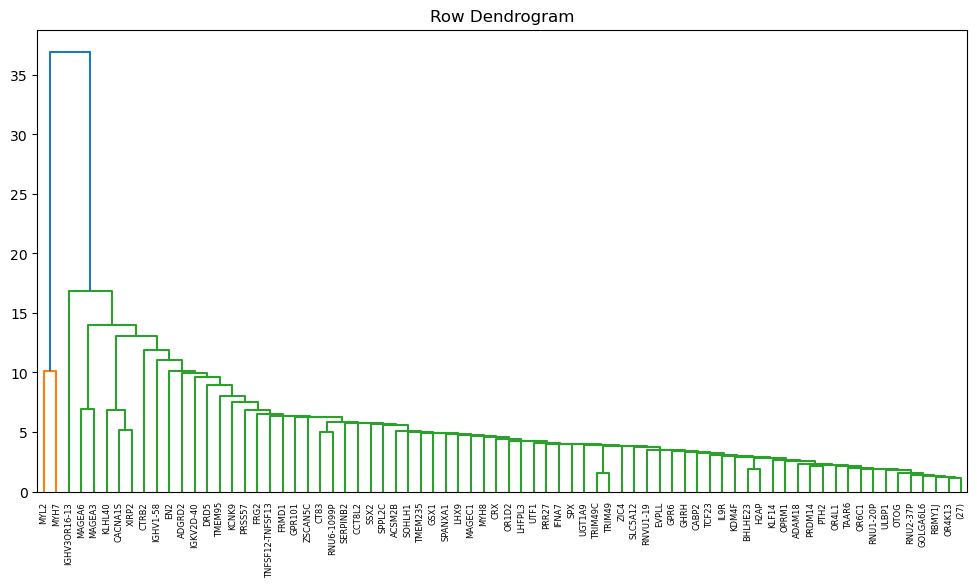

In [147]:
from scipy.cluster.hierarchy import dendrogram

# Plot the row dendrogram
plt.figure(figsize=(12, 6))
gene_plot = dendrogram(row_linkage, 
                       labels=expression_df_heatmap.index, 
                       truncate_mode='lastp', 
                       p=int(0.75 * len(row_linkage)), show_leaf_counts=True)
plt.title('Row Dendrogram')
plt.show()

# Plot the column dendrogram
plt.figure(figsize=(12, 6))
sample_plot = dendrogram(col_linkage, labels=expression_df_heatmap.columns, orientation='top', truncate_mode='lastp', 
                       p=int(0.75 * len(row_linkage)), 
                       show_leaf_counts=True)
plt.title('Column Dendrogram')
plt.show()


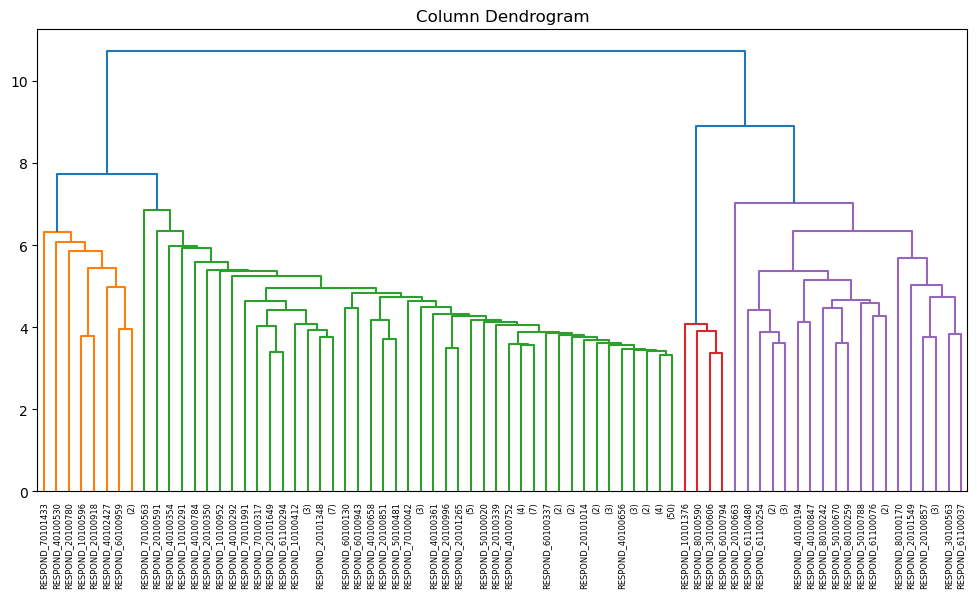

In [148]:
# Plot the column dendrogram
plt.figure(figsize=(12, 6))
sample_plot = dendrogram(col_linkage, labels=expression_df_heatmap.columns, orientation='top', truncate_mode='lastp', 
                       p=int(0.75 * len(row_linkage)), 
                       show_leaf_counts=True)
plt.title('Column Dendrogram')
plt.show()

## questions
### How do we prep data for heat map? In other tutorials, I see negative values. Like -1 to 2. I'm guessing some might be plotting the fold change calculation with baseline as healthy samples. 

In [239]:
def histogram_of_column(df, column):
    # Plot the distribution of p-values
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, color='blue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel('P-values')
    plt.ylabel('Frequency')
    plt.show()

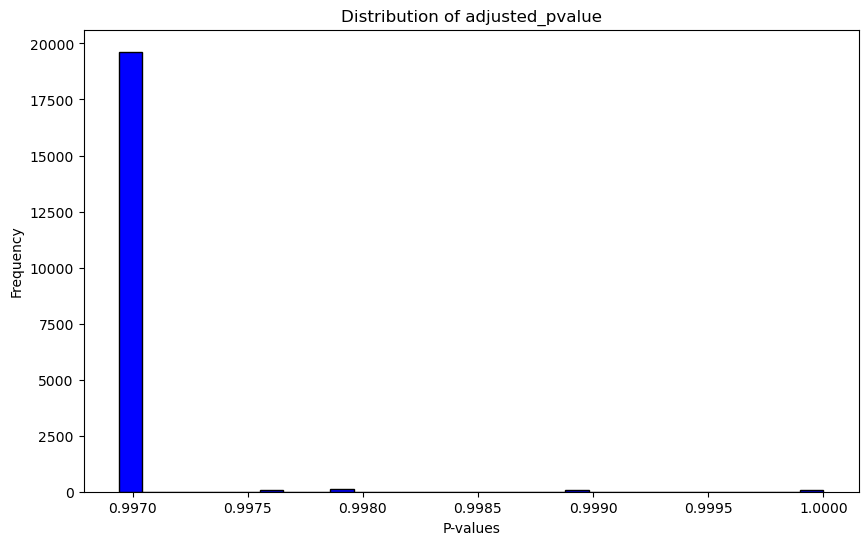

In [240]:
histogram_of_column(volcano_plot_df, column='adjusted_pvalue')

In [118]:
def volcano_plot(file_path, yaxis, xaxis):
    df = pd.read_csv(file_path)
    plt.scatter(x=df[xaxis],y=df[yaxis].apply(lambda x:-np.log10(x)),s=1)

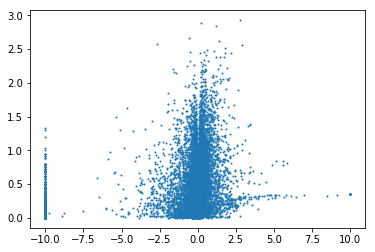

In [126]:
volcano_plot('5_112_RPL10', yaxis='pvalue', xaxis='logFC')